### Задачи

1. как получить векторы решения для разных кубитных размерностей? $\textbf{done}$
2. что такое evolution_time и trotter_steps в методе TridiagonalToeplitz?
3. как это преобразовать в квантовую схему? $\textbf{done}$
4. как это полностью руками сделать в виде схемы? Нативные функции очень долгие.
5. насколько это будет долго считаться? Можно ли какого-нибудь простого Пуассона посчитать?

In [1]:
import numpy as np
from scipy.sparse import diags
import math 

from qiskit.quantum_info import Statevector
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble, Aer, IBMQ, execute
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.algorithms.linear_solvers.matrices import TridiagonalToeplitz
from qiskit.algorithms.linear_solvers.observables import MatrixFunctional
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
def qft_rotations(qc, qr, n, start=0):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return qc
    n -= 1
    qc.h(qr[start+n])
    for qubit in range(n):
        qc.cp(-np.pi/2**(n-qubit), qr[start+qubit], qr[start+n])
    qft_rotations(qc, qr, n, start)

def qft_dagger_rotations(qc, qr, n, init, start=0):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if init == n:
        return qc
    for qubit in range(init):
        qc.cp(np.pi/2**(init-qubit), qr[start+qubit], qr[start+init])
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qc.h(qr[start+init])
    init += 1
    qft_dagger_rotations(qc, qr, n, init, start)
    
def swap_registers(qc, qr, n, start):
    for qubit in range(n//2):
        qc.swap(start+qubit, start+n-qubit-1)
    return qc

def qft(qc, qr, n, start=0):
    """QFT on the first n qubits in circuit"""
    qft_rotations(qc, qr, n, start)
    swap_registers(qc, qr, n, start)

    return qc    
    
def qft_dagger(qc, qr, n, init, start=0):
    """QFT on the first n qubits in circuit"""
    swap_registers(qc, qr, n, start)
    qft_dagger_rotations(qc, qr, n, init, start)

    return qc  

In [3]:
# Система уравнение NxN
num_qubits = 1
matrix_size = 2 ** num_qubits

a = 1
b = -1/3
matrix = diags([b, a, b], [-1, 0, 1], shape=(matrix_size, matrix_size)).toarray()
vector = np.array([1] + [0]*(matrix_size - 1))
tridi_matrix = TridiagonalToeplitz(num_qubits, a, b)

# это классический референс
classical_solution = NumPyLinearSolver().solve(matrix, vector / np.linalg.norm(vector))

# эти начинают лажать с размерности СЛУ 8 и выше (почему?)
hhl_solution = HHL().solve(matrix, vector)
tridi_hhl_solution = HHL().solve(tridi_matrix.matrix, vector)

# это даёт верное решение
tridi_solution = HHL().solve(tridi_matrix, vector) # матрица вставляется в неявном виде

In [4]:
"""
Евклидовы нормы векторов решения
"""
print(classical_solution.euclidean_norm)
print(hhl_solution.euclidean_norm)
print(tridi_hhl_solution.euclidean_norm)
print(tridi_solution.euclidean_norm)

"""
Векторы решения
"""
# Где находится наш вектор решения в состоянии регистра
n = int(Statevector(hhl_solution.state).dim/2)
step = matrix.shape[0]
n_tridi = int(np.log2(matrix.shape[0]))

hhl_sv = Statevector(hhl_solution.state).data[n:n+step]
tridi_hhl_sv = Statevector(tridi_hhl_solution.state).data[n:n+step]
tridi_sv = Statevector(tridi_solution.state).data[2**(n_tridi-1)*n:2**(n_tridi-1)*n+step]

print(classical_solution.state)
print(hhl_sv*hhl_solution.euclidean_norm/np.linalg.norm(hhl_sv))
print(tridi_hhl_sv*tridi_hhl_solution.euclidean_norm/np.linalg.norm(tridi_hhl_sv))
print(np.real(tridi_sv*tridi_solution.euclidean_norm/np.linalg.norm(tridi_sv)))

1.1858541225631423
1.1858541225631418
1.1858541225631418
1.185854122563142
[1.125 0.375]
[1.125-3.42679447e-16j 0.375-5.97546483e-17j]
[1.125-3.42679447e-16j 0.375-5.97546483e-17j]
[1.125 0.375]


In [5]:
matrix

array([[ 1.        , -0.33333333],
       [-0.33333333,  1.        ]])

In [6]:
t = 3/8
Evol_t_2 = HamiltonianGate(matrix, t/2, r'$e^{iAt/2}$').control(1)
Evol_t_4 = HamiltonianGate(matrix, t/4, r'$e^{iAt/4}$').control(1)
Evol_t_2_dg = HamiltonianGate(matrix, -t/2, r'$e^{-iAt/2}$').control(1)
Evol_t_4_dg = HamiltonianGate(matrix, -t/4, r'$e^{-iAt/4}$').control(1)

In [7]:
qr = QuantumRegister(2)
qc = QuantumCircuit(qr)
qc.compose(Evol_t_2, qubits=[0, 1], inplace=True)
qc.compose(Evol_t_4, qubits=[0, 1], inplace=True)
qc.compose(Evol_t_4_dg, qubits=[0, 1], inplace=True)
qc.compose(Evol_t_2_dg, qubits=[0, 1], inplace=True)
qc.draw()

q130_0: ───────■──────────────■──────────────■───────────────■────────
        ┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐
q130_1: ┤ $e^{iAt/2}$ ├┤ $e^{iAt/4}$ ├┤ $e^{-iAt/4}$ ├┤ $e^{-iAt/2}$ ├
        └─────────────┘└─────────────┘└──────────────┘└──────────────┘

In [8]:
Statevector(qc).data

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [9]:
matrix = np.array(
    [[1.5, 0.5],
    [0.5, 1.5]])
# matrix = np.array(
#     [[1., 1/3],
#     [1/3, 1]])

t = 2*np.pi * 3/8
a = 1.5
b = 0.5
ham = HamiltonianGate(matrix, t, r'ham')
qr = QuantumRegister(1)
qc = QuantumCircuit(qr)
qc.compose(ham, qubits=[0], inplace=True)
backend = Aer.get_backend('unitary_simulator')
job = execute(qc, backend)
result = job.result()
print(np.around(result.get_unitary(qc), 3))

[[-0.354+0.146j  0.354+0.854j]
 [ 0.354+0.854j -0.354+0.146j]]


In [10]:
t = 2*np.pi
Evol_t_2 = HamiltonianGate(matrix, -t/2, r'$e^{iAt/2}$').control(1)
Evol_t_4 = HamiltonianGate(matrix, -t/4, r'$e^{iAt/4}$').control(1)
Evol_t_2_dg = HamiltonianGate(matrix, t/2, r'$e^{-iAt/2}$').control(1)
Evol_t_4_dg = HamiltonianGate(matrix, t/4, r'$e^{-iAt/4}$').control(1)

In [11]:
qr = QuantumRegister(3)
qc = QuantumCircuit(qr)
qc.compose(Evol_t_4, qubits=[1, 2], inplace=True)
qc.compose(Evol_t_2, qubits=[0, 2], inplace=True)
qc.draw()
backend = Aer.get_backend('unitary_simulator')
job = execute(qc, backend)
result = job.result()
print(np.around(result.get_unitary(qc), 3))

[[ 1. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j ]
 [ 0. -0.j  -0. -0.j   0. -0.j   0. -0.j   0. -0.j   1. -0.j   0. -0.j
   0. -0.j ]
 [-0. +0.j  -0. +0.j  -0.5+0.5j -0. +0.j  -0. +0.j  -0. +0.j  -0.5-0.5j
  -0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j  -0.5-0.5j  0. +0.j   0. +0.j   0. +0.j
  -0.5+0.5j]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j   1. +0.j   0. +0.j   0. +0.j
   0. +0.j ]
 [ 0. -0.j   1. -0.j   0. -0.j   0. -0.j   0. -0.j  -0. -0.j   0. -0.j
   0. -0.j ]
 [-0. +0.j  -0. +0.j  -0.5-0.5j -0. +0.j  -0. +0.j  -0. +0.j  -0.5+0.5j
  -0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j  -0.5+0.5j  0. +0.j   0. +0.j   0. +0.j
  -0.5-0.5j]]


In [12]:
qr = QuantumRegister(3)
qc = QuantumCircuit(qr)
qc.cu3(-np.pi/2, -np.pi/2, np.pi/2, 1,2)
qc.u1(3*np.pi/4, 1)
qc.cx(0,2)
qc.draw()
backend = Aer.get_backend('unitary_simulator')
job = execute(qc, backend)
result = job.result()
print(np.around(result.get_unitary(qc), 3))

[[ 1. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   1. +0.j   0. +0.j
   0. +0.j ]
 [-0. +0.j  -0. +0.j  -0.5+0.5j -0. +0.j  -0. +0.j  -0. +0.j  -0.5-0.5j
  -0. +0.j ]
 [-0. +0.j  -0. +0.j  -0. +0.j  -0.5-0.5j -0. +0.j  -0. +0.j  -0. +0.j
  -0.5+0.5j]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j   1. +0.j   0. +0.j   0. +0.j
   0. +0.j ]
 [ 0. +0.j   1. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j ]
 [-0. +0.j  -0. +0.j  -0.5-0.5j -0. +0.j  -0. +0.j  -0. +0.j  -0.5+0.5j
  -0. +0.j ]
 [-0. +0.j  -0. +0.j  -0. +0.j  -0.5+0.5j -0. +0.j  -0. +0.j  -0. +0.j
  -0.5-0.5j]]


<ipython-input-12-46373e04759a>:3: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  qc.cu3(-np.pi/2, -np.pi/2, np.pi/2, 1,2)
<ipython-input-12-46373e04759a>:4: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  qc.u1(3*np.pi/4, 1)


In [13]:
def old_hhl_4qubit_qcircuit(theta):
    
    qr = QuantumRegister(4)
    qc = QuantumCircuit(qr)
    
    #|b> encoding
    qc.ry(theta, qr[3])
    qc.barrier()
    
    # QFT
    qc.h([1,2])
    qc.barrier()
    
    # Hamiltonian simulation  
    qc.cu3(-np.pi/2, -np.pi/2, np.pi/2, 2,3)
    qc.u1(3*np.pi/4, 2)
    qc.cx(1,3)
    qc.barrier()
    
    # Inverse QFT
    qc.swap(1,2)
    qc.h(2)
    qc.cu1(-np.pi/2, 1,2)
    qc.h(1)
    qc.barrier()
    
    # Controlled rotation
    qc.swap(qr[1],qr[2])
    qc.barrier()
    qc.cu3(np.pi/16, 0, 0, 1, 0)
    qc.cu3(np.pi/32, 0, 0, 2, 0)
    qc.barrier()
    qc.swap(qr[1],qr[2])
    qc.barrier()
    
    # Inverse inverse QFT
    qc.h(1)
    qc.cu1(np.pi/2, 1,2)
    qc.h(2)
    qc.swap(1,2)
    qc.barrier()
    
    #Inverse Hamiltonian simulation 
    qc.cx(1,3)
    qc.u1(-3*np.pi/4, 2)
    qc.cu3(-np.pi/2, np.pi/2, -np.pi/2, 2,3)
    qc.barrier()
    
    # Inverse QFT on computational basis
    qc.h([1,2])

    return qc

def hhl_4qubit_qcircuit(theta):
    
    qr = QuantumRegister(4)
    qc = QuantumCircuit(qr)
    
    #|b> encoding
    qc.ry(theta, qr[3])
    qc.barrier()
    
    # QFT
    qc.h([1,2])
    
    # Hamiltonian simulation
    qc.barrier()
    qc.compose(Evol_t_4, qubits=[2, 3], inplace=True)
    qc.compose(Evol_t_2, qubits=[1, 3], inplace=True)
    qc.barrier()
    
    # Inverse QFT
    qc.swap(qr[1],qr[2])
    qft(qc, qr, n=2, start=1)
    
    # Controlled rotation
    qc.barrier()
    qc.cu3(np.pi/16, 0, 0, 1, 0)
    qc.cu3(np.pi/32, 0, 0, 2, 0)
    qc.barrier()
    
    # Inverse inverse QFT
    qft_dagger(qc, qr, n=2, init=0, start=1)
    qc.swap(qr[1],qr[2])
    
    #Inverse Hamiltonian simulation
    qc.barrier()
    qc.compose(Evol_t_2_dg, qubits=[1, 3], inplace=True)
    qc.compose(Evol_t_4_dg, qubits=[2, 3], inplace=True)
    qc.barrier()
    
    # Inverse QFT on computational basis
    qc.h([1,2])
    
    return qc

In [14]:
# Система уравнение NxN
num_qubits = 1
matrix_size = 2 ** num_qubits

a = 1.5
b = 0.5
matrix = diags([b, a, b], [-1, 0, 1], shape=(matrix_size, matrix_size)).toarray()

In [15]:
hhl_4qubit_qcircuit(np.pi).draw()

░       ░                                ░                   »
q158_0: ──────────░───────░────────────────────────────────░───────────────────»
                  ░ ┌───┐ ░                                ░                   »
q158_1: ──────────░─┤ H ├─░───────────────────────■────────░──X───────■────────»
                  ░ ├───┤ ░                       │        ░  │ ┌───┐ │P(-π/2) »
q158_2: ──────────░─┤ H ├─░────────■──────────────┼────────░──X─┤ H ├─■────────»
        ┌───────┐ ░ └───┘ ░ ┌──────┴──────┐┌──────┴──────┐ ░    └───┘          »
q158_3: ┤ Ry(π) ├─░───────░─┤ $e^{iAt/4}$ ├┤ $e^{iAt/2}$ ├─░───────────────────»
        └───────┘ ░       ░ └─────────────┘└─────────────┘ ░                   »
«                 ░ ┌──────────────┐┌──────────────┐ ░                       »
«q158_0: ─────────░─┤ U3(π/16,0,0) ├┤ U3(π/32,0,0) ├─░───────────────────────»
«        ┌───┐    ░ └──────┬───────┘└──────┬───────┘ ░    ┌───┐              »
«q158_1: ┤ H ├─X──░────────■───────────────┼─────────░──X─┤ H ├─■────────────»
«        └───┘ │  ░                        │         ░  │ └───┘ │P(π/2) ┌───┐»
«q158_2: ──────X──░────────────────────────■─────────░──X───────■───────┤ H ├»
«                 ░                                  ░                  └───┘»
«q158_3: ─────────░──────────────────────────────────░───────────────────────»
«                 ░                                  ░                       »
«            ░                                  ░      
«q158_0: ────░──────────────────────────────────░──────
«            ░                                  ░ ┌───┐
«q158_1: ─X──░────────■─────────────────────────░─┤ H ├
«         │  ░        │                         ░ ├───┤
«q158_2: ─X──░────────┼───────────────■─────────░─┤ H ├
«            ░ ┌──────┴───────┐┌──────┴───────┐ ░ └───┘
«q158_3: ────░─┤ $e^{-iAt/2}$ ├┤ $e^{-iAt/4}$ ├─░──────
«            ░ └──────────────┘└──────────────┘ ░

In [16]:
#old_hhl_4qubit_qcircuit(np.pi).draw()

In [17]:
vector = np.array([0.440, -0.898])

classical_solution = NumPyLinearSolver().solve(matrix, vector / np.linalg.norm(vector))
print(classical_solution.state)

theta = np.pi
old_hhl_sv = Statevector(old_hhl_4qubit_qcircuit(theta)).data
old_hhl_sv = old_hhl_sv/np.linalg.norm(old_hhl_sv)
hhl_sv = Statevector(hhl_4qubit_qcircuit(theta)).data
hhl_sv = hhl_sv/np.linalg.norm(hhl_sv)

old_hhl_ans = [
    old_hhl_sv[1]+old_hhl_sv[3]+old_hhl_sv[5]+old_hhl_sv[7],
    old_hhl_sv[9]+old_hhl_sv[11]+old_hhl_sv[13]+old_hhl_sv[15]
]
hhl_ans = [
    hhl_sv[1]+hhl_sv[3]+hhl_sv[5]+hhl_sv[7],
    hhl_sv[9]+hhl_sv[11]+hhl_sv[13]+hhl_sv[15]
]

print(np.around(old_hhl_ans, 3))
print(np.around(hhl_ans, 3))

[ 0.55449889 -0.78349843]
[-0.024-0.j  0.074+0.j]
[-0.024+0.j  0.074+0.j]


<ipython-input-13-3ad9dfd9acff>:23: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(-np.pi/2, 1,2)


In [18]:
1/np.sin(np.pi/64)

20.380016247096112

In [19]:
hhl_sv = Statevector(hhl_4qubit_qcircuit(theta)).data
print(np.around(hhl_sv/np.linalg.norm(hhl_sv), 3))

[ 0.002+0.j -0.024+0.j  0.   -0.j  0.   +0.j  0.   -0.j  0.   -0.j
 -0.   -0.j -0.   +0.j  0.997-0.j  0.074-0.j  0.   +0.j  0.   +0.j
 -0.   +0.j -0.   +0.j  0.   +0.j  0.   +0.j]


In [20]:
old_hhl_sv = Statevector(old_hhl_4qubit_qcircuit(theta)).data
print(np.around(old_hhl_sv/np.linalg.norm(old_hhl_sv), 3))

[ 0.002+0.j -0.024+0.j -0.   -0.j  0.   +0.j -0.   +0.j -0.   -0.j
  0.   -0.j  0.   -0.j  0.997-0.j  0.074-0.j -0.   -0.j  0.   +0.j
 -0.   +0.j -0.   +0.j -0.   -0.j  0.   -0.j]


In [21]:
matrix

array([[1.5, 0.5],
       [0.5, 1.5]])

In [22]:
np.around(np.real(Statevector(hhl_4qubit_qcircuit(theta)).data), 3)

array([ 0.002, -0.024,  0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,
        0.997,  0.074,  0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   ])

In [23]:
np.around(np.real(Statevector(hhl_4qubit_qcircuit(np.pi/2)).data), 3)

array([ 0.706,  0.035,  0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,
        0.706,  0.035, -0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ])

In [24]:
np.around(np.real(Statevector(hhl_4qubit_qcircuit(-2.23)).data), 3)

array([ 0.437,  0.054, -0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,
       -0.894, -0.077, -0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ])

In [25]:
np.around(np.real(Statevector(hhl_4qubit_qcircuit(0.57)).data), 3)

array([ 0.957,  0.064,  0.   ,  0.   , -0.   , -0.   , -0.   , -0.   ,
        0.282, -0.003, -0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ])

In [26]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(4, 'q')
creg_c = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.u3(pi, 0, 0, qreg_q[3])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
circuit.h(qreg_q[1])
circuit.h(qreg_q[2])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
circuit.cu3(-pi/2, -pi/2, pi/2, qreg_q[2], qreg_q[3])
circuit.u1(3*pi/4, qreg_q[2])
circuit.cx(qreg_q[1], qreg_q[3])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
circuit.swap(qreg_q[1], qreg_q[2])
circuit.h(qreg_q[2])
circuit.cu1(-pi/2, qreg_q[1], qreg_q[2])
circuit.h(qreg_q[1])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
circuit.swap(qreg_q[1], qreg_q[2])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
circuit.cu3(pi/16, 0, 0, qreg_q[1], qreg_q[0])
circuit.cu3(pi/32, 0, 0, qreg_q[2], qreg_q[0])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
circuit.swap(qreg_q[1], qreg_q[2])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
circuit.h(qreg_q[1])
circuit.cu1(pi/2, qreg_q[1], qreg_q[2])
circuit.h(qreg_q[2])
circuit.swap(qreg_q[1], qreg_q[2])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
circuit.cx(qreg_q[1], qreg_q[3])
circuit.u1(-3*pi/4, qreg_q[2])
circuit.cu3(-pi/2, pi/2, -pi/2, qreg_q[2], qreg_q[3])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
circuit.h(qreg_q[1])
circuit.h(qreg_q[2])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

print(np.around(Statevector(circuit).data, 3))

[ 0.002+0.j -0.024+0.j -0.   -0.j  0.   +0.j -0.   +0.j -0.   -0.j
  0.   -0.j  0.   -0.j  0.997-0.j  0.074-0.j -0.   -0.j  0.   +0.j
 -0.   +0.j -0.   +0.j -0.   -0.j  0.   -0.j]


<ipython-input-26-632c640fe191>:8: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  circuit.u3(pi, 0, 0, qreg_q[3])


## Quantum Fourier examples

In [27]:
qr = QuantumRegister(5)
qc = QuantumCircuit(qr)

def qft_3_qubits(qc, qr):
    qc.h(qr[2])
    qc.cp(np.pi/2, qr[1], qr[2]) # CROT from qubit 1 to qubit 2
    qc.cp(np.pi/4, qr[0], qr[2]) # CROT from qubit 2 to qubit 0
    qc.h(qr[1])
    qc.cp(np.pi/2, qr[0], qr[1]) # CROT from qubit 0 to qubit 1
    qc.h(qr[0])
    qc.swap(qr[0],qr[2])

qft_3_qubits(qc, qr[1:4])

qc.draw()

q167_0: ─────────────────────────────────────────────
                                             ┌───┐   
q167_1: ───────────────■─────────────■───────┤ H ├─X─
                       │       ┌───┐ │P(π/2) └───┘ │ 
q167_2: ──────■────────┼───────┤ H ├─■─────────────┼─
        ┌───┐ │P(π/2)  │P(π/4) └───┘               │ 
q167_3: ┤ H ├─■────────■───────────────────────────X─
        └───┘                                        
q167_4: ─────────────────────────────────────────────

In [28]:
def qft_rotations(qc, qr, n, start=0):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return qc
    n -= 1
    qc.h(qr[start+n])
    for qubit in range(n):
        qc.cp(np.pi/2**(n-qubit), qr[start+qubit], qr[start+n])
    qc.barrier()
    qft_rotations(qc, qr, n, start)

def qft_dagger_rotations(qc, qr, n, init, start=0):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if init == n:
        return qc
    for qubit in range(init):
        qc.cp(-np.pi/2**(init-qubit), qr[start+qubit], qr[start+init])
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qc.h(qr[start+init])
    init += 1
    qc.barrier()
    qft_dagger_rotations(qc, qr, n, init, start)
    
def swap_registers(qc, qr, n):
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    return qc

def qft(qc, qr, n, start=0):
    """QFT on the first n qubits in circuit"""
    qft_rotations(qc, qr, n, start)
    qc.barrier()
    swap_registers(qc, qr, n)
    qc.barrier()
    return qc    
    
def qft_dagger(qc, qr, n, init, start=0):
    """QFT on the first n qubits in circuit"""
    swap_registers(qc, qr, n)
    qc.barrier()
    qft_dagger_rotations(qc, qr, n, init, start)
    qc.barrier()
    return qc   
        
n_qubits = 3
qr = QuantumRegister(n_qubits)
qc = QuantumCircuit(qr)
#qc.x(0)
#qc.x(1)
qc.barrier()
qft(qc, qr, n=2, start=1)
qft_dagger(qc , qr, n=2, init=0, start=1)

qc.draw()

░                ░       ░  ░     ░     ░       ░                 ░ »
q168_0: ─░────────────────░───────░──░──X──░──X──░───────░─────────────────░─»
         ░                ░ ┌───┐ ░  ░  │  ░  │  ░ ┌───┐ ░                 ░ »
q168_1: ─░───────■────────░─┤ H ├─░──░──X──░──X──░─┤ H ├─░──■──────────────░─»
         ░ ┌───┐ │P(π/2)  ░ └───┘ ░  ░     ░     ░ └───┘ ░  │P(-π/2) ┌───┐ ░ »
q168_2: ─░─┤ H ├─■────────░───────░──░─────░─────░───────░──■────────┤ H ├─░─»
         ░ └───┘          ░       ░  ░     ░     ░       ░           └───┘ ░ »
«         ░ 
«q168_0: ─░─
«         ░ 
«q168_1: ─░─
«         ░ 
«q168_2: ─░─
«         ░

In [29]:
print(np.around(Statevector(qc).data, 3)) # какого черта тут комплексные числа вылезают?

[1.+0.j 0.+0.j 0.-0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


C:\anaconda\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


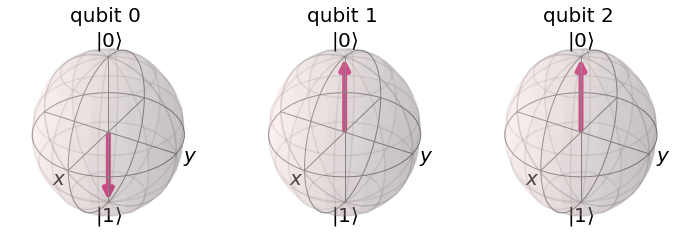

In [30]:
# Create the circuit
qr = QuantumRegister(3)
qc = QuantumCircuit(qr)

# Encode the state
qc.x(0)

sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

C:\anaconda\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


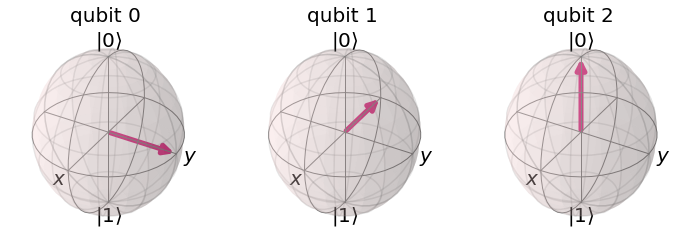

In [31]:
qft(qc, qr, n=2)
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

## Quantum Phase Estimation examples

### Precise problem

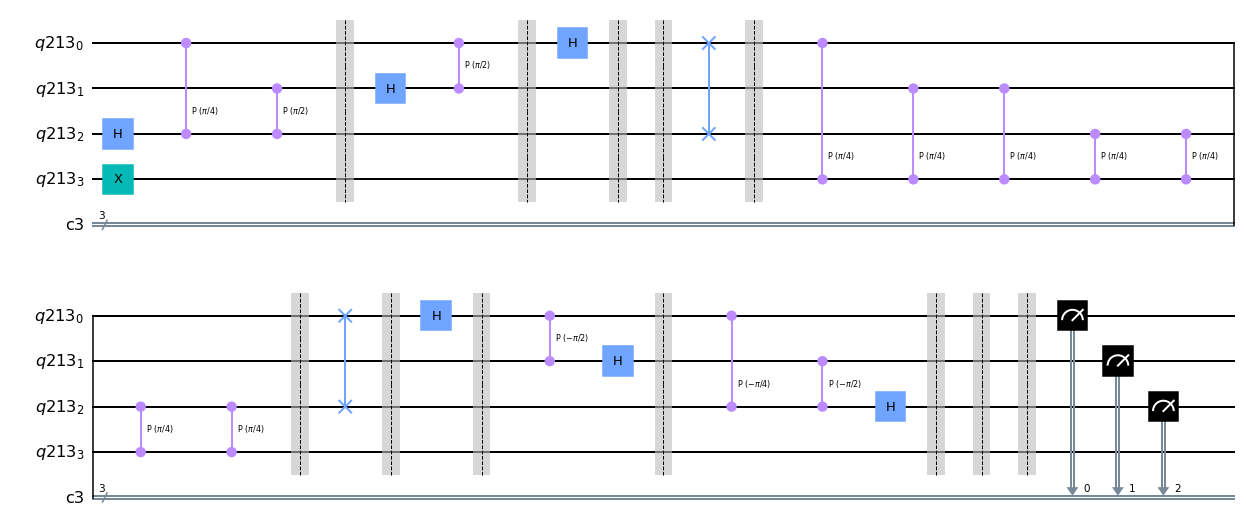

In [37]:
cr = ClassicalRegister(3)
qr = QuantumRegister(4)
qpe = QuantumCircuit(qr, cr)
qpe.x(qr[3])
qft(qpe, qr, n=3)
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(math.pi/4, qr[counting_qubit], 3); # This is C-U
    repetitions *= 2
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, qr, n=3, init=0)
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(qr[n],cr[n])
    
qpe.draw('mpl')

C:\anaconda\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


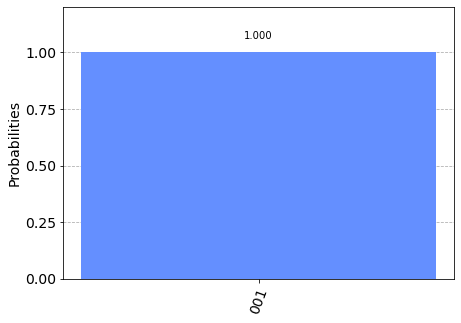

In [33]:
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 2048
t_qpe = transpile(qpe, qasm_sim)
qobj = assemble(t_qpe, shots=shots)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

### Inprecise problem

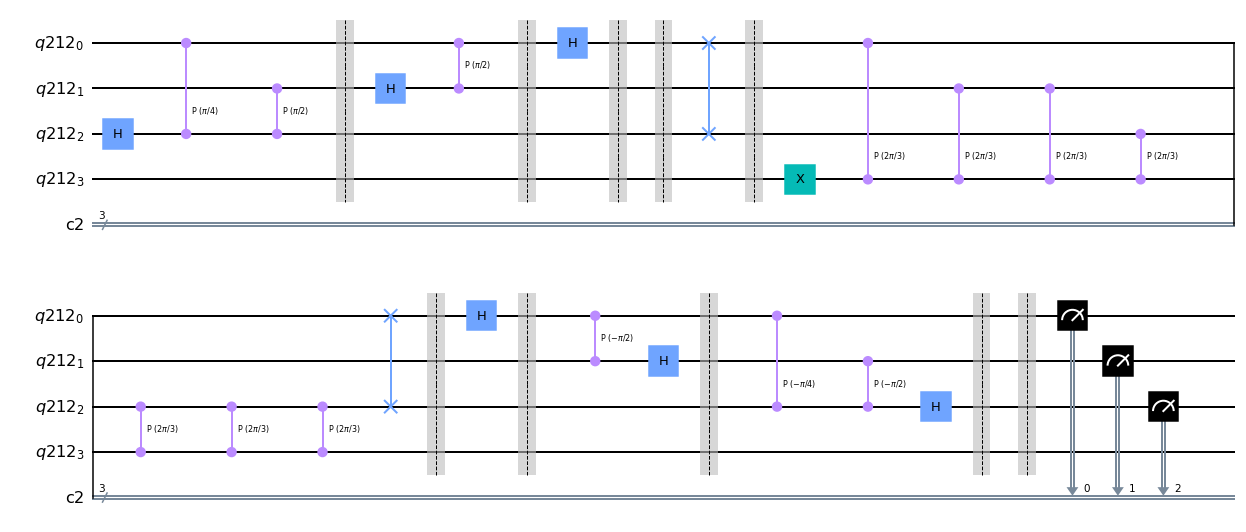

In [36]:
counting_reg_size = 3
qreg_size = 4

# Create and set up circuit
qr = QuantumRegister(qreg_size)
cr = ClassicalRegister(counting_reg_size)
qpe2 = QuantumCircuit(qr, cr)

# Apply H-Gates to counting qubits:
qft(qpe2, qr, n=counting_reg_size)

# Prepare our eigenstate |psi>:
qpe2.x(counting_reg_size)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(counting_reg_size):
    for i in range(repetitions):
        qpe2.cp(angle, qr[counting_qubit], qr[counting_reg_size]);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe2, qr, n=counting_reg_size, init=0)

# Measure of course!
#qpe2.measure(qc, qr)
for n in range(counting_reg_size):
    qpe2.measure(qr[n], cr[n])

qpe2.draw('mpl')

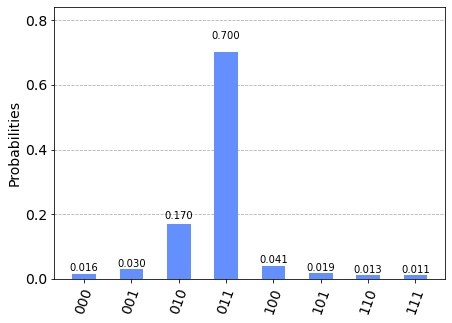

In [35]:
# Let's see the results!
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 4096
t_qpe2 = transpile(qpe2, qasm_sim)
qobj = assemble(t_qpe2, shots=shots)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)